In [8]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipython-input-388934090.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('RELIANCE.NS', start = '2023-12-28', end = '2025-12-28', interval = '1d')
[*********************100%***********************]  1 of 1 completed


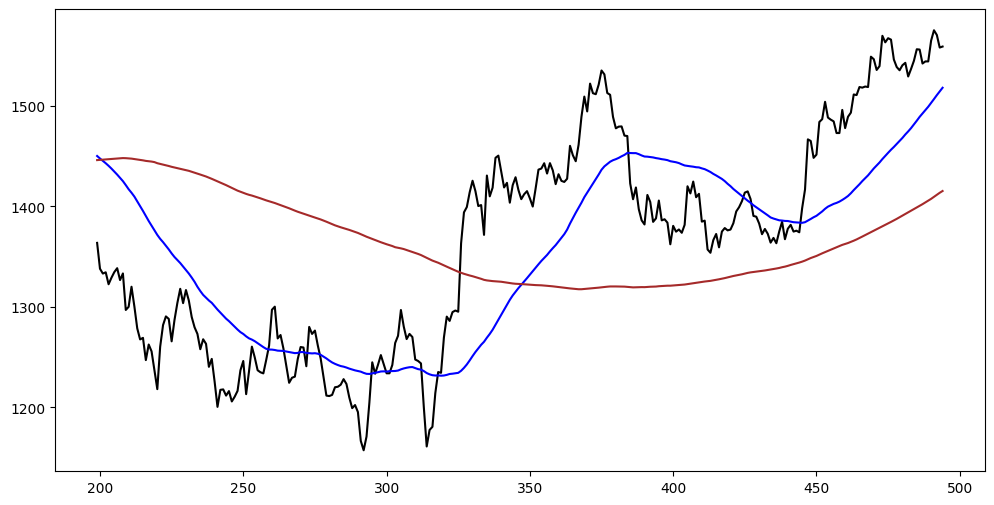

In [9]:
#Part-1
df = yf.download('RELIANCE.NS', start = '2023-12-28', end = '2025-12-28', interval = '1d')
df.reset_index(inplace = True)


#1 SMA
df['SMA_50'] = df['Close'].rolling(window = 50).mean()
df['SMA_200'] = df['Close'].rolling(window = 200).mean()

df.dropna(inplace = True)
plt.figure(figsize=(12,6))
plt.plot(df['Close'],color = 'black')
plt.plot(df['SMA_50'],color = 'blue')
plt.plot(df['SMA_200'],color = 'brown')
plt.show()

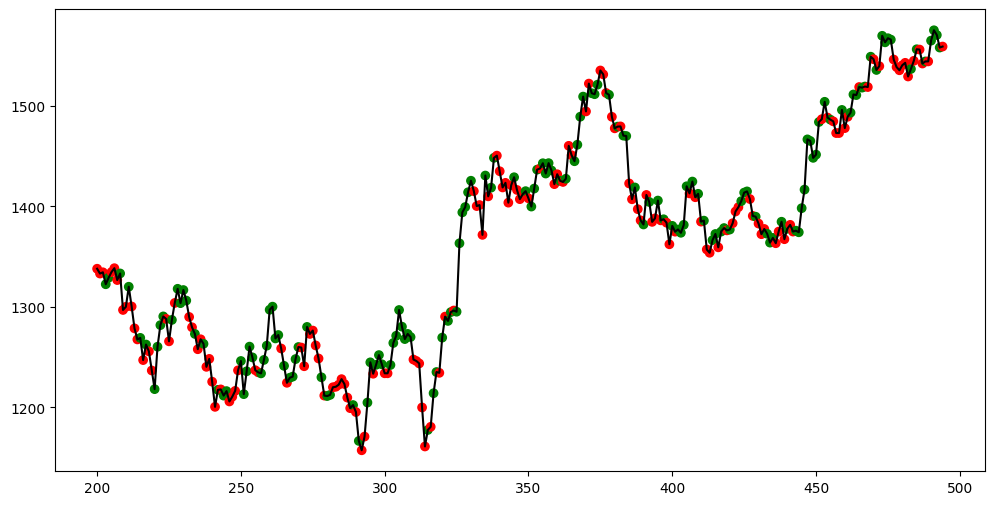

In [10]:
#2 GAP
df['Gap'] = df['Open'] - df['Close'].shift(1)
df.dropna(inplace = True)
colors = df['Gap'].apply(lambda x: 'green' if x > 0 else 'red')

plt.figure(figsize=(12,6))
plt.plot(df['Close'],color = 'black')
plt.scatter(df.index, df['Close'], c=colors)
plt.show()

In [ ]:

#3 VWAP
df_vwap = yf.download("RELIANCE.NS", period="1d", interval="5m")
df_vwap.reset_index(inplace=True)



df_vwap['VWAP'] = (((df_vwap['High'] + df_vwap['Low'] + df_vwap['Close']) / 3) * df_vwap['Volume']).cumsum() / df_vwap['Volume'].cumsum()


plt.figure(figsize=(12,6))
plt.plot(df_vwap['Close'], color='black')
plt.plot(df_vwap['VWAP'], color='orange')


In [54]:
#Part-2
df = yf.download('TCS.NS', start ='2023-01-01', end = '2023-12-31', interval ='1d')
df.columns = df.columns.get_level_values(0)

/tmp/ipython-input-1688570047.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('TCS.NS', start ='2023-01-01', end = '2023-12-31', interval ='1d')
[*********************100%***********************]  1 of 1 completed


In [57]:
#Q1
def BB(df):

  df['BBMiddle'] = df['Close'].rolling(window = 20).mean()
  df['BBUpper'] = df['BBMiddle'] + 2*df['Close'].rolling(window = 20).std()
  df['BBLower'] = df['BBMiddle'] - 2*df['Close'].rolling(window = 20).std()

  return df


def rsi(df,period):
  df['diff'] = df['Close'].diff()
  df['Gain'] = (np.where(df['diff'] < 0, 0, df['diff']))
  df['Loss'] = abs(np.where(df['diff'] > 0, 0 , df['diff']))
  df['avg_gain'] = df['Gain'].rolling(period).mean()
  df['avg_loss'] = df['Loss'].rolling(period).mean()
  df['RS'] = df['avg_gain']/df['avg_loss']
  df['RSI'] = 100 - (100/(1+df['RS']))

  return df


def macd(df,short_period,long_period,p):
  df['long_ema'] = df['Close'].ewm(span=long_period,adjust=False).mean()
  df['short_ema'] = df['Close'].ewm(span=short_period,adjust=False).mean()
  df['MACD'] = df['short_ema'] - df['long_ema']
  df['signal_line'] = df['MACD'].ewm(span=p,adjust=False).mean()
  df['macd_signal'] = df['signal_line'] - df['MACD']

  return df


def ADX(df):
  pdm = df['High'].diff()
  mdm = df['Low'].diff()

  pdm = pdm.where((pdm > mdm) & (pdm > 0), 0.0)
  mdm = -mdm.where((mdm > pdm) & (mdm > 0), 0.0)

  tr = pd.concat([(df['High']-df['Low']).abs(),(df['High']-df['Close'].shift(1)).abs(),(df['Low']-df['Close'].shift(1)).abs()],axis = 1)\
       .max(axis = 1)
  atr = tr.rolling(window = 14).mean()

  pdi = (pdm.rolling(window = 14).mean()/atr)*100
  mdi = (mdm.rolling(window = 14).mean()/atr)*100
  dx = (abs(pdi - mdi) / (pdi + mdi)) * 100

  df['ADX'] = dx.rolling(14).mean()
  df['+DI'] = pdi
  df['-DI'] = mdi

  return df


def STOCHO(df):
  low_14 = df['Low'].rolling(window = 14).min()
  high_14 = df['High'].rolling(window = 14).max()

  df['%K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
  df['%D'] = df['%K'].rolling(3).mean()

  return df


def ATR(df):
  tr = pd.concat([(df['High']-df['Low']).abs(),(df['High']-df['Close'].shift(1)).abs(),(df['Low']-df['Close'].shift(1)).abs()],axis = 1)\
       .max(axis = 1)
  df['ATR'] = tr.rolling(window = 14).mean()

  return df

df = BB(df)
df = rsi(df,14)
df = macd(df,12,26,9)
df = ADX(df)
df = STOCHO(df)
df = ATR(df)





In [58]:
#Q2
def count_signals(signal_series):
    return (signal_series == 1).sum(), (signal_series == -1).sum()


df['BB_signal'] = np.where(
    (df['Close'] > df['BBLower']) & (df['Close'].shift(1) <= df['BBLower'].shift(1)),
    1,
    np.where(
        (df['Close'] < df['BBUpper']) & (df['Close'].shift(1) >= df['BBUpper'].shift(1)),
        -1,
        0))


df['RSI_signal'] = np.where(
    (df['RSI'] > 30) & (df['RSI'].shift(1) <= 30), 1,
    np.where((df['RSI'] < 70) & (df['RSI'].shift(1) >= 70), -1, 0))


df['MACD_signal_flag'] = np.where(
    ((df['macd_signal']<0) & (df['macd_signal'].shift(1)>0)),
    1,
    np.where(
        (df['macd_signal']>0) & (df['macd_signal']<0),
        -1,
        0))


df['ADX_signal'] = np.where(
    (df['+DI'] > df['-DI']) & (df['ADX'] > 25),
    1,
    np.where((df['-DI'] > df['+DI']) & (df['ADX'] > 25),
             -1,
             0))


df['STOCH_signal'] = np.where(
    (df['%K'] > df['%D']) & (df['%K'] < 20) & (df['%D'] < 20),
    1,
    np.where(
        (df['%K'] < df['%D']) & (df['%K'] > 80) & (df['%D'] > 80),
        -1,
        0))



df['ATR_signal'] = np.where(
    df['Close'] > df['High'].shift(1) + df['ATR'],
    1,
    np.where(df['Close'] < df['Low'].shift(1) - df['ATR'],
             -1, 0))



signals = {
    "Bollinger Bands": count_signals(df['BB_signal']),
    "RSI": count_signals(df['RSI_signal']),
    "MACD": count_signals(df['MACD_signal_flag']),
    "ADX": count_signals(df['ADX_signal']),
    "Stochastic": count_signals(df['STOCH_signal']),
    "ATR": count_signals(df['ATR_signal']),
}

signal_df = pd.DataFrame.from_dict(
    signals,
    orient='index',
    columns=['Buy Signals', 'Sell Signals']
)

print(signal_df)


                 Buy Signals  Sell Signals
Bollinger Bands            3             7
RSI                       10            12
MACD                      10             0
ADX                      122             0
Stochastic                14            24
ATR                        9             3
